In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
%matplotlib inline

In [2]:
class Player(object):
    def __init__(self, player_id, x, y):
        self.player_id = player_id
        self.x = x
        self.y = y

In [3]:
class Pass(object):
    def __init__(self, pass_id, line_num, time_start, time_end, sender_id, receiver_id):
        self.pass_id = pass_id
        self.line_num = line_num
        self.time_start = time_start
        self.time_end = time_end
        self.sender_id = sender_id
        self.receiver_id = receiver_id
        self.sender = None
        self.receiver = None
        self.sender_friends = None
        self.sender_opponents = None
        self.players = {}
        
    def add_player(self, player_id, x, y):
        self.players[player_id] = Player(player_id, x, y)
        
    def get_sender_friends(self):
        if not self.sender_friends:
            self.sender_friends = {candidate_id: self.players[candidate_id] for candidate_id in self.players.keys() if candidate_id != self.sender_id and self.__in_same_team(self.sender_id, candidate_id)}
        return self.sender_friends
    
    def get_sender_opponents(self):
        if not self.sender_opponents:
            self.sender_opponents = {candidate_id: self.players[candidate_id] for candidate_id in self.players.keys() if not self.__in_same_team(self.sender_id, candidate_id)}
        return self.sender_opponents

    def __in_same_team(self, player_id_1, player_id_2):
        return (player_id_1 - 14.5) * (player_id_2 - 14.5) > 0

In [4]:
def pass_builder(pass_id, line_num, tokens):
    players_count = 28
    time_start = int(tokens[0])
    time_end = int(tokens[1])
    sender_id = int(tokens[2])
    receiver_id = int(tokens[3])
    a_pass = Pass(pass_id, line_num, time_start, time_end, sender_id, receiver_id)
    for i in range(players_count):
        x = tokens[4 + i]
        y = tokens[4 + players_count + i]
        if not x or not y:
            continue
        a_pass.add_player(i+1, float(x), float(y))
    return a_pass

In [5]:
def get_passes():
    first_line = True
    line_num = 0
    pass_id = 0
    passes = []
    for line in open('passes.csv'):
        line_num += 1
        if first_line:
            first_line = False
            continue
        tokens = line.split(',')
        if len(tokens) < 60: continue
        a_pass = pass_builder(pass_id, line_num, tokens)
        # validate
        if a_pass.sender_id not in a_pass.players: continue
        passes.append(a_pass)
        pass_id += 1
    return passes

In [6]:
passes = get_passes()

In [7]:
def plot_pass(a_pass, show_receiver=True):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # plot field
    #x1, y1 = [-5500, 5500], [0, 0]
    #x2, y2 = [0, 0], [3500, -3500]
    plt.xlim(-5250, 5250), plt.ylim(-3400, 3400)
    #plt.plot(x1, y1, x2, y2, marker = 'o', color = 'black')
    plt.plot([0, 0], [3400, -3400], color = 'black')
    #plt.axis([-5250, 5250, -3400, 3400])
    
    # plot center circle
    center_circle = plt.Circle((0,0), 915, color = 'black', fill = False)
    ax.add_patch(center_circle)
    plt.plot(0, 0, marker = 'o', color = 'black')
    
    # Penalty area
    plt.plot([3600, 3600], [2016, -2016], color = 'black')
    plt.plot([3600, 5250], [2016, 2016], color = 'black')
    plt.plot([3600, 5250], [-2016, -2016], color = 'black')
    plt.plot(4150, 0, marker = 'o', color = 'black')
    
    plt.plot([-3600, -3600], [2016, -2016], color = 'black')
    plt.plot([-3600, -5250], [2016, 2016], color = 'black')
    plt.plot([-3600, -5250], [-2016, -2016], color = 'black')
    plt.plot(-4150, 0, marker = 'o', color = 'black')
    
    # Goal area
    plt.plot([4700, 4700], [916, -916], color = 'black')
    plt.plot([4700, 5250], [916, 916], color = 'black')
    plt.plot([4700, 5250], [-916, -916], color = 'black')
    
    plt.plot([-4700, -4700], [916, -916], color = 'black')
    plt.plot([-4700, -5250], [916, 916], color = 'black')
    plt.plot([-4700, -5250], [-916, -916], color = 'black')
    
    # Arcs
    leftArc = Arc((-4150,0),height=1830,width=1830,angle=0,theta1=310,theta2=50,color="black")
    rightArc = Arc((4150,0),height=1830,width=1830,angle=0,theta1=130,theta2=230,color="black")
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)
    
    # plot sender
    sender = a_pass.players[a_pass.sender_id]
    sender_x = sender.x
    sender_y = sender.y
    plt.plot(sender_x, sender_y, 'bo')
    plt.plot(sender_x, sender_y, 'b+')
    plt.annotate(sender.player_id, (sender_x, sender_y))
    
    # plot friends
    sender_friends = a_pass.get_sender_friends()
    friends_x, friends_y = [a_pass.players[friend].x for friend in sender_friends], [a_pass.players[friend].y for friend in sender_friends]
    friend_ids = [a_pass.players[friend].player_id for friend in sender_friends]
    plt.plot(friends_x, friends_y, 'go')
    for i, txt in enumerate(friend_ids):
        plt.annotate(txt, (friends_x[i], friends_y[i]))
    
    # plot opponent
    sender_opponents = a_pass.get_sender_opponents()
    opponents_x, opponents_y = [a_pass.players[opponent].x for opponent in sender_opponents], [a_pass.players[opponent].y for opponent in sender_opponents]
    opponent_ids = [a_pass.players[opponent].player_id for opponent in sender_opponents]
    plt.plot(opponents_x, opponents_y, 'ro')
    for i, txt in enumerate(opponent_ids):
        plt.annotate(txt, (opponents_x[i], opponents_y[i]))
    
    if show_receiver:
        # plot receiver
        receiver = a_pass.players[a_pass.receiver_id]
        receiver_x = receiver.x
        receiver_y = receiver.y
        color = 'co' if a_pass.receiver_id in sender_friends else 'mo'
        status = 'friend' if a_pass.receiver_id in sender_friends else 'opponent'
        status_x = 4000 if a_pass.receiver_id in sender_friends else 3500
        plt.plot(receiver_x, receiver_y, color)
        plt.annotate(receiver.player_id, (receiver_x, receiver_y))
        plt.text(status_x, -3000, status)
    
    duration = (a_pass.time_end - a_pass.time_start) / 1000.0
    minute = a_pass.time_start // 60000
    second = (a_pass.time_start - minute * 60000) / 1000.0
    plt.title("PassId: {}, Start time: {}:{}, duration: {} seconds".format(a_pass.pass_id, minute, second, duration))
    plt.show()

### Start of game

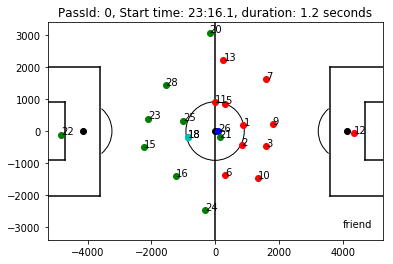

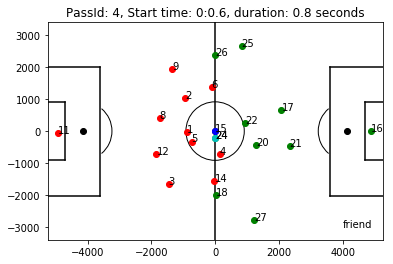

In [8]:
plot_pass(passes[0])
plot_pass(passes[4])

### Goal keeper kick far away and pass to opponent

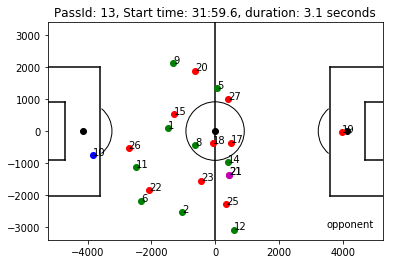

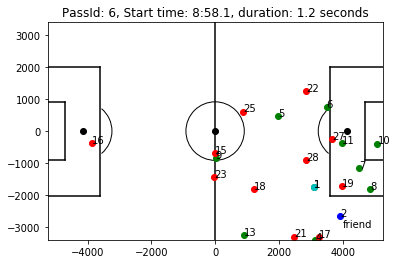

In [18]:
plot_pass(passes[13])
plot_pass(passes[6])

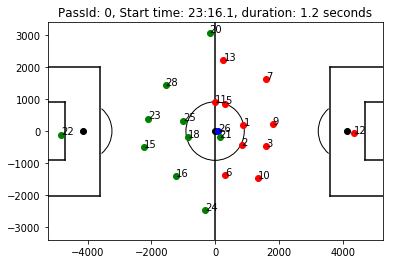

In [ ]:
#plot_pass(passes[3])
plot_pass(passes[0], False)